<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/gwdm-notebooks/blob/main/GWDM_AquiferMapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In [ ]:
#@markdown ### **Installing packages**
%%capture
!pip install geopandas
!pip install rasterio
!pip install rioxarray
!pip install gstools
!pip install matplotlib
#!pip install kats
!pip install pyod

In [ ]:
#@markdown ### **Importing packages**
import calendar
import copy
import datetime
import math
import os
import shutil
import tempfile
import time
import urllib
from pathlib import Path
from timeit import default_timer as timer
from urllib import request
from xml.etree import cElementTree as ET

import geopandas as gpd
import gstools as gs
import netCDF4
import numpy as np
import pandas as pd
import requests
import xarray
import rioxarray
from scipy import interpolate
from shapely import wkt
from shapely.geometry import mapping
from google.colab import files
import matplotlib.pyplot as plt
import re

# Uploading Aquifer Data

In [ ]:
#@markdown ### **Uploading Aquifer File**
upload_aquifer = files.upload()
aquifer = gpd.GeoDataFrame.from_file(list(upload_aquifer.keys())[0])
aquifer

Saving sunflower.geojson to sunflower.geojson


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,28,133,00695787,28133,Sunflower,Sunflower County,06,H1,G4020,NaN,NaN,NaN,A,1807187011,23747316,+33.6055289,-090.5950901,"POLYGON ((-90.71613 33.27003, -90.71628 33.270..."


In [ ]:
#@markdown ### **Uploading wells file**
upload_wells = files.upload()
wells = pd.read_csv(list(upload_wells.keys())[0])
wells_gdf = gpd.GeoDataFrame(wells, geometry=gpd.points_from_xy(wells["long_dec"], wells["lat_dec"]))
wells

Saving sunflower_wells.csv to sunflower_wells.csv


,Well_ID,Well_Name,lat_dec,long_dec,GSE,COUNTYFP,geometry
0,331615090422801,133S0131 SUNFLOWER,33.270700,-90.707719,105.06,133,POINT (-90.70772 33.27070)
1,331617090381601,133T0111 SUNFLOWER,33.271510,-90.637871,105.00,133,POINT (-90.63787 33.27151)
2,331628090384001,133T0115 SUNFLOWER,33.274444,-90.644444,105.00,133,POINT (-90.64444 33.27444)
3,331655090350401,133T0048 SUNFLOWER,33.285169,-90.582089,110.82,133,POINT (-90.58209 33.28517)
4,331751090395201,133S0504 SUNFLOWER,33.298253,-90.662381,111.35,133,POINT (-90.66238 33.29825)
...,...,...,...,...,...,...,...
262,335849090333601,133A0604 SUNFLOWER,33.979417,-90.559567,148.64,133,POINT (-90.55957 33.97942)
263,335851090333901,A0031 SUNFLOWER,33.980945,-90.560651,148.00,133,POINT (-90.56065 33.98095)
264,335860090334401,133A0089 SUNFLOWER,33.983100,-90.562128,150.53,133,POINT (-90.56213 33.98310)
265,335905090343001,133A0054 SUNFLOWER,33.984834,-90.575096,145.00,133,POINT (-90.57510 33.98483)


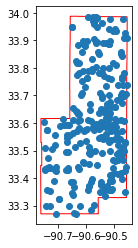

In [ ]:
#@markdown ### **Plotting aquifer and wells**
fig, ax = plt.subplots()
aquifer.plot(color="none", edgecolor="red", ax=ax)
wells_gdf.plot(ax=ax)

In [ ]:
#@markdown ### **Uploading timeseries**
upload_timeseries = files.upload()
measurements = pd.read_csv(list(upload_timeseries.keys())[0])
measurements["Date"] = pd.to_datetime(measurements.Date, infer_datetime_format=True)
no_uniquewells = len(measurements["Well_ID"].unique())
measurements

Saving sunflower_ts.csv to sunflower_ts.csv


,Well_ID,Date,GW_measurement
0,331615090422801,2015-10-14,30.94
1,331615090422801,2016-04-07,25.06
2,331615090422801,2016-10-06,28.85
3,331615090422801,2017-04-11,28.08
4,331615090422801,2017-10-10,28.99
...,...,...,...
3325,335860090334401,2021-04-08,46.61
3326,335860090334401,2021-10-18,48.42
3327,335860090334401,2022-04-11,46.60
3328,335905090343001,2008-08-04,44.00


In [ ]:
#@markdown ### **Defining aquifer bounds**
bbox = aquifer.bounds.values[0].tolist()
bbox

[-90.76448518617087, 33.27000369418701, -90.45027276113794, 33.9875932793764]

# Accessing Data from Server

In [ ]:
#@markdown ### **Defining functions for this section**

def get_pdsi_df(aquifer_gdf):
    data_dir = "/content"
    nc_file = os.path.join(data_dir, "pdsi.nc4")
    pdsi_ds = xarray.open_dataset(nc_file, decode_times=False)
    units, _, reference_date = pdsi_ds.time.attrs["units"].split("since")
    pdsi_ds["time"] = pd.date_range(
        start=reference_date, periods=pdsi_ds.sizes["time"], freq="MS"
    )
    ds = pdsi_ds["pdsi_filled"].to_dataset()
    ds["pdsi_filled"] = ds["pdsi_filled"].rio.write_crs("epsg:4326")
    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    # aquifer_geom = wkt.loads(aquifer_obj[0])
    # aquifer_gdf = gpd.GeoDataFrame(
    #     {"name": ["random"], "geometry": [aquifer_geom]}, crs="EPSG:4326"
    # )
    clipped_ds = ds.rio.clip(
        aquifer_gdf.geometry.apply(mapping),
        aquifer_gdf.crs,
        drop=True,
        all_touched=True,
    ).drop("spatial_ref")
    filled_df = (
        clipped_ds.to_dataframe()
        .reset_index()
        .groupby("time")["pdsi_filled"]
        .mean()
        .reset_index()
        .set_index("time")
    )
    return filled_df

# outdated function sarva wanted replaced
def get_time_bounds(url):
    # This function returns the first and last available time
    # from a url of a getcapabilities page located on a Thredds Server
    f = urllib.request.urlopen(url)
    tree = ET.parse(f)
    root = tree.getroot()
    # These lines of code find the time dimension information for the netcdf on the Thredds server
    dim = root.findall(".//{http://www.opengis.net/wms}Dimension")
    dim = dim[0].text
    times = dim.split(",")
    times.pop(0)
    timemin = times[0]
    timemax = times[-1]
    # timemin and timemax are the first and last available times on the specified url
    return timemin, timemax
#
# # sarva's new function
# def get_time_bounds(url):
#     # This function returns the first and last available time
#     # from a url of a getcapabilities page located on a Thredds Server
#     f = urllib.request.urlopen(url)
#     tree = ET.parse(f)
#     root = tree.getroot()
#     # These lines of code find the time dimension information for the netcdf on the Thredds server
#     dim = root.findall(".//{http://www.opengis.net/wms}Dimension")
#     dim = dim[0].text
#     times = dim.split(",")
#     timemin = re.sub(r"[\n\t\s]*", "", times[0])
#     timemax = re.sub(r"[\n\t\s]*", "", times[-1])
#     # timemin and timemax are the first and last available times on the specified url
#     return timemin, timemax



def get_thredds_value(server, layer, bbox):
    # This function returns a pandas dataframe of the timeseries values of a specific layer
    # at a specific latitude and longitude from a file on a Thredds server
    # server: the url of the netcdf desired netcdf file on the Thredds server to read
    # layer: the name of the layer to extract timeseries information from for the netcdf file
    # lat: the latitude of the point at which to extract the timeseries
    # lon: the longitude of the point at which to extract the timeseries
    # returns df: a pandas dataframe of the timeseries at lat and lon for the layer in the server netcdf file
    # calls the getTimeBounds function to get the first and last available times for the netcdf file on the server
    time_min, time_max = get_time_bounds(
        server + "?service=WMS&version=1.3.0&request=GetCapabilities"
    )
    print(time_min)
    print(time_max)
    # These lines properly format a url request for the timeseries of a speific layer from a netcdf on
    # a Thredds server
    server = f"{server}?service=WMS&version=1.3.0&request=GetFeatureInfo&CRS=CRS:84&QUERY_LAYERS={layer}"
    server = f"{server}&X=0&Y=0&I=0&J=0&BBOX={bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}&LAYER={layer}"
    server = f"{server}&WIDTH=1&Height=1&INFO_FORMAT=text/xml&STYLES=raster/default"
    server = f"{server}&TIME={time_min}/{time_max}"
    print(server)
    f = request.urlopen(server)
    tree = ET.parse(f)
    root = tree.getroot()
    features = root.findall("FeatureInfo")
    times = []
    values = []
    for child in features:
        time = datetime.datetime.strptime(child[0].text, "%Y-%m-%dT%H:%M:%S.%fZ")
        times.append(time)
        values.append(child[1].text)

    df = pd.DataFrame(index=times, columns=[layer], data=values)
    df[layer] = df[layer].replace("none", np.nan).astype(float)
    return df

def sat_resample(gldas_df):
    # resamples the data from both datasets to a monthly value,
    # uses the mean of all measurements in a month
    # first resample to daily values, then take the start of the month
    gldas_df = gldas_df.resample("D").mean()
    # D is daily, mean averages any values in a given day, if no data in that day, gives NaN

    gldas_df.interpolate(method="pchip", inplace=True, limit_area="inside")

    gldas_df = gldas_df.resample("MS").first()
    # MS means "month start" or to the start of the month, this is the interpolated value

    return gldas_df

def sat_rolling_window(gldas_df):
    years = [1, 3, 5, 10]
    names = list(gldas_df.columns)
    new_names = copy.deepcopy(
        names
    )  # names is a list of the varibiles in the data frame, need to unlink for loop
    # This loop adds the yearly, 3-year, 5-year, and 10-year rolling averages of each variable to the dataframe
    # rolling averages uses the preceding time to compute the last value,
    # e.g., using the preceding 5 years of data to get todays
    for name in names:
        for year in years:
            new = name + "_yr" + str(year).zfill(2)
            gldas_df[new] = gldas_df[name].rolling(year * 12).mean()
            new_names.append(new)
    return gldas_df, new_names

In [ ]:
#@markdown ### **Downloading PDSI data from server**
pdsi_response = requests.get("https://github.com/BYU-Hydroinformatics/gwdm-data/blob/main/pdsi.nc4?raw=true")
with open("pdsi.nc4", "wb") as binary_file:
    # Write bytes to file
    binary_file.write(pdsi_response.content)
pdsi_df = get_pdsi_df(aquifer)

In [ ]:
#@markdown ### **Downloading soil moisture data from server**
SERVER2 = "https://tethyswa.servirglobal.net/thredds/wms/testAll/psl/soilw.mon.mean.nc"
#SERVER2 = "https://www.psl.noaa.gov/thredds/wms/Datasets/cpcsoil/soilw.mon.mean.nc"
LAYER2 = "soilw"  # name of data column to be returned
soilw_df = get_thredds_value(SERVER2, LAYER2, bbox)

1948-02-01T00:00:00.000Z
2022-09-01T00:00:00.000Z
https://tethyswa.servirglobal.net/thredds/wms/testAll/psl/soilw.mon.mean.nc?service=WMS&version=1.3.0&request=GetFeatureInfo&CRS=CRS:84&QUERY_LAYERS=soilw&X=0&Y=0&I=0&J=0&BBOX=-90.76448518617087,33.27000369418701,-90.45027276113794,33.9875932793764&LAYER=soilw&WIDTH=1&Height=1&INFO_FORMAT=text/xml&STYLES=raster/default&TIME=1948-02-01T00:00:00.000Z/2022-09-01T00:00:00.000Z


In [ ]:
#@markdown ### **Resampling the data grid size and adding rolling average**
gldas_df = pd.concat([pdsi_df, soilw_df], join="outer", axis=1)
gldas_df = sat_resample(gldas_df)
gldas_df, names = sat_rolling_window(gldas_df)

# Temporal Interpolation

In [ ]:
#@markdown ### **Defining functions for this section**

# def smooth(y, box_size):
#     """moving window function using convolution
#     y:          1D vector of values
#     box_size:   size of the moving window, should be an odd integer, will set if not
#     this function pads the data so that the edges are equal to the
#     orginal value
#     """
#     if int(box_size) % 2 == 0:  # make sure box_size is odd integer
#         box_size = int(box_size) + 1  # if even, add one
#     else:
#         box_size = int(box_size)  # if not even (e.g., float), make integer

#     box = np.ones(box_size) / box_size  # convolution kernal for moving window
#     y_pad = np.pad(
#         y, (box_size // 2, box_size - 1 - box_size // 2), mode="edge"
#     )  # padd for edge effects
#     y_smooth = np.convolve(
#         y_pad, box, mode="valid"
#     )  # convolve, 'valid' key work trims pad
#     return y_smooth

# def plot_anomalies(df, x='date', y='amount'):

#     # categories will be having values from 0 to n
#     # for each values in 0 to n it is mapped in colormap
#     categories = df['Predictions'].to_numpy()
#     colormap = np.array(['g', 'r'])

#     f = plt.figure(figsize=(12, 4))
#     f = plt.scatter(df[x], df[y], c=colormap[categories])
#     f = plt.xlabel(x)
#     f = plt.ylabel(y)
#     # f = plt.xticks(rotation=90)
#     plt.show()

# def extract_query_objects(region_id, aquifer_id, variable):
#     session = get_session_obj()
#     aquifer_obj = (
#         session.query(gf2.ST_AsText(Aquifer.geometry), Aquifer.aquifer_name)
#         .filter(Aquifer.region_id == region_id, Aquifer.id == aquifer_id)
#         .first()
#     )
#     bbox = wkt.loads(aquifer_obj[0]).bounds
#     wells_query = session.query(Well).filter(Well.aquifer_id == aquifer_id)
#     wells_query_df = pd.read_sql(wells_query.statement, session.bind)
#     well_ids = [int(well_id) for well_id in wells_query_df.id.values]
#     # well_dict = {well.id: well.gse for well in wells_query_df.itertuples()}
#     m_query = session.query(Measurement).filter(
#         Measurement.well_id.in_(well_ids), Measurement.variable_id == variable
#     )
#     measurements_df = pd.read_sql(m_query.statement, session.bind)
#     # measurements_df['gse'] = measurements_df['well_id'].map(well_dict)
#     measurements_df["date"] = pd.to_datetime(
#         measurements_df.ts_time, infer_datetime_format=True
#     )

#     session.close()

#     return bbox, wells_query_df, measurements_df, aquifer_obj    

def extract_well_data(name, well_df, min_samples=0, ts_col="ts_value", date_col="date"):
    if len(well_df) >= min_samples:
        # if (well_df['date'].min() < start_date) and (well_df['date'].max() > end_date):
        # elevation = well_df['gse'].unique()[0]
        df = pd.DataFrame(
            index=well_df[date_col].values,
            data=well_df[ts_col].values,
            columns=[name],
        )
        df = df[np.logical_not(df.index.duplicated())]
        return df

def interp_well(wells_df, gap_size, pad, spacing):
    well_interp_df = pd.DataFrame()
    # create a time index to interpolate over - cover entire range
    interp_index: pd.DatetimeIndex = pd.date_range(
        start=min(wells_df.index), freq=spacing, end=max(wells_df.index)
    )
    # loop over each well, interpolate data using pchip
    for well in wells_df:
        temp_df = wells_df[well].dropna()  # available data for a well

        x_index = temp_df.index.astype("int")  # dates for available data

        x_diff = temp_df.index.to_series().diff()  # data gap sizes

        fit2 = interpolate.pchip(x_index, temp_df)  # pchip fit to data

        ynew = fit2(interp_index.astype("int"))  # interpolated data on full range

        interp_df = pd.DataFrame(ynew, index=interp_index, columns=[well])

        # replace data in gaps of > 1 year with nans

        gaps = np.where(x_diff > gap_size)  # list of indexes where gaps are large

        for g in gaps[0]:
            start = x_diff.index[g - 1] + datetime.timedelta(days=pad)

            end = x_diff.index[g] - datetime.timedelta(days=pad)

            interp_df[start:end] = np.nan

        beg_meas_date = x_diff.index[0]  # date of 1st measured point

        end_meas_date = temp_df.index[-1]  # date of last measured point

        mask1 = (
            interp_df.index < beg_meas_date
        )  # locations of data before 1st measured point

        interp_df[mask1] = np.nan  # blank out data before 1st measured point

        mask2 = (
            interp_df.index >= end_meas_date
        )  # locations of data after the last measured point

        interp_df[mask2] = np.nan  # blank data from last measured point

        # add the interp_df data to the full data frame

        well_interp_df = pd.concat(
            [well_interp_df, interp_df], join="outer", axis=1, sort=False
        )
    return well_interp_df

def norm_training_data(in_df, ref_df):
    norm_in_df = (in_df - ref_df.min().values) / (
        ref_df.max().values - ref_df.min().values
    )  # use values as df sometimes goofs
    return norm_in_df

def input_to_hidden(x, Win, b):
    # setup matrixes
    a = np.dot(x, Win) + b
    a = np.maximum(a, 0, a)  # relu
    return a

def predict(in_values, W_in, b, W_out):
    x = input_to_hidden(in_values, W_in, b)
    y = np.dot(x, W_out)
    return y

def impute_data(comb_df, well_names, names):
    # for out test set we will impute everything
    imputed_df = pd.DataFrame(index=comb_df.index)

    for well in well_names:  # list of the wells in the aquifer
        train_nona_df = comb_df.dropna(
            subset=[well]
        )  # drop any rows with na in well (measured) data
        labels_df = train_nona_df[
            well
        ]  # measured data used as "labels" or truth in training
        tx_df = train_nona_df[
            names
        ]  # data we will predict with only over the test period
        all_tx_df = comb_df[names]  # data over the full period, will use for imputation

        tx = tx_df.values  # convert to an array
        x1 = np.column_stack(np.ones(tx.shape[0])).T  # bias vector of 1's
        tx = np.hstack((tx, x1))  # training matrix
        ty = labels_df.values
        input_length = tx.shape[1]
        hidden_units = 500
        lamb_value = 100
        W_in = np.random.normal(size=[input_length, hidden_units])
        b = np.random.normal(size=[hidden_units])

        # now do the matrix multiplication
        X = input_to_hidden(
            tx, W_in, b
        )  # setup matrix for multiplication, it is a function
        I = np.identity(X.shape[1])
        I[X.shape[1] - 1, X.shape[1] - 1] = 0
        I[X.shape[1] - 2, X.shape[1] - 2] = 0
        W_out = np.linalg.lstsq(X.T.dot(X) + lamb_value * I, X.T.dot(ty), rcond=-1)[0]
        all_tx_values = all_tx_df.values
        a1 = np.column_stack(np.ones(all_tx_values.shape[0])).T
        all_tx_values = np.hstack((all_tx_values, a1))
        predict_values = predict(all_tx_values, W_in, b, W_out)  # it is a function
        #pre_name = f"{well}_imputed"
        pre_name = f"{well}"
        imputed_df[pre_name] = pd.Series(predict_values, index=imputed_df.index)

    return imputed_df

def renorm_data(in_df, ref_df):
    assert in_df.shape[1] == ref_df.shape[1], "must have same # of columns"
    renorm_df = (
        in_df * (ref_df.max().values - ref_df.min().values)
    ) + ref_df.min().values
    return renorm_df

In [ ]:
#@markdown ### **Setting parameters for temporal and spatial interpolation**
#temporal
min_samples = 5
gap_size = "3650 days"
pad = 365
spacing = "1MS"


In [ ]:
#@markdown ### **Collect well data that qualifies for use in interpolation**
wells_df = pd.concat([
        extract_well_data(name, group, min_samples, "GW_measurement", "Date")
        for name, group in measurements.groupby("Well_ID")],
    axis=1, sort=False,)

In [ ]:
#@markdown ### **Cleaning up wells dataframe**
wells_df.drop_duplicates(inplace=True)
wells_df[wells_df == 0] = np.nan
# wells_df.to_csv("wells_one.csv")
wells_df.dropna(thresh=min_samples, axis=1, inplace=True)
no_qualifiedwells = len(wells_df.columns.values)
no_droppedwells = no_uniquewells - no_qualifiedwells
print(no_uniquewells,  ' total wells')
print(no_droppedwells,  ' wells dropped')
print(no_qualifiedwells,  ' qualified for use in interpolation')

267  total wells
166  wells dropped
101  qualified for use in interpolation


In [ ]:
#@markdown ### **Running simple pchip temporal interpolation**
well_interp_df = interp_well(wells_df, gap_size, pad, spacing)
well_interp_df.dropna(thresh=min_samples, axis=1, inplace=True)

<ipython-input-12-98346615c5fe>:85: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_index = temp_df.index.astype("int")  # dates for available data
<ipython-input-12-98346615c5fe>:91: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  ynew = fit2(interp_index.astype("int"))  # interpolated data on full range


In [ ]:
#@markdown ### **Running machine learning algorithm to fill gaps**
# combine the  data from the wells and the satellite observations  to a single dataframe (combined_df)
# this will have a row for every measurement (on the start of the month) a column for each well,
# and a column for pdsi and soilw and their rolling averages, and potentially offsets
combined_df = pd.concat(
    [well_interp_df, gldas_df], join="outer", axis=1, sort=False
)
combined_df.dropna(
    subset=names, inplace=True
)  # drop rows where there are no satellite data
combined_df.dropna(how="all", axis=1, inplace=True)

norm_df = norm_training_data(combined_df, combined_df)
norm_df.dropna(how="all", axis=1, inplace=True)
well_names = [col for col in well_interp_df.columns if col in norm_df.columns]
imputed_norm_df = impute_data(norm_df, well_names, names)
ref_df = combined_df[well_names]
imputed_df = renorm_data(imputed_norm_df, ref_df)

imputed_well_names = imputed_df.columns  # create a list of well names
loc_well_names = [(strg.replace("_imputed", "")) for strg in imputed_well_names]  # strip off "_imputed"

<ipython-input-12-98346615c5fe>:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  imputed_df[pre_name] = pd.Series(predict_values, index=imputed_df.index)


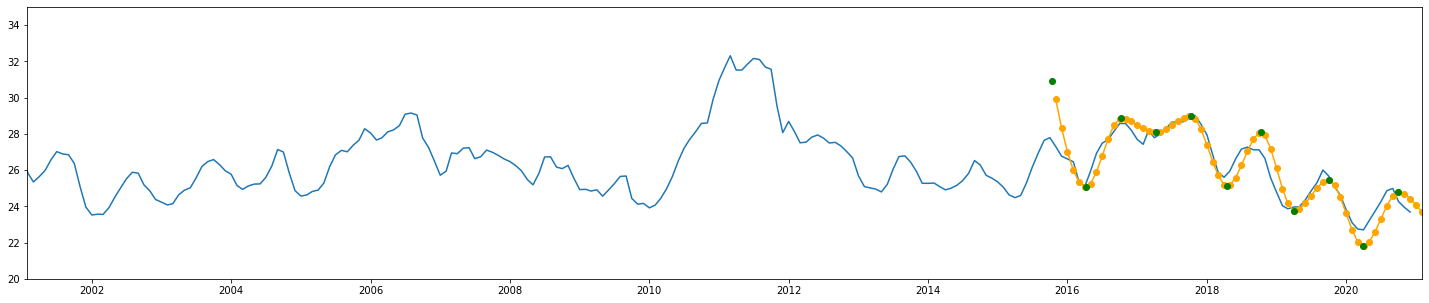

In [ ]:
#formatting dates for plotting
imputed_date =  pd.to_datetime(imputed_df.index.values)
interp_date =  pd.to_datetime(well_interp_df.index.values)
wells_date =  pd.to_datetime(wells_df.index.values)

#ignoring NANs for plotting
well_interp_df.dropna()
wells_df.dropna()

well_no = 0

#plotting the three dataframes: measurments, pchip, and machine learning
fig, ax = plt.subplots(1, 1, figsize=(25,5))
ax.set_xlim([datetime.date(2001, 1, 26), datetime.date(2021, 2, 1)])
ax.set_ylim([20, 35])
ax.plot(imputed_date, imputed_df[imputed_df.columns[well_no]]) #machine learning
ax.plot(interp_date, well_interp_df[well_interp_df.columns[well_no]], marker = "o", color = 'orange') #pchip
ax.plot(wells_date, wells_df[wells_df.columns[well_no]], marker = "o", linestyle = 'none', color = 'green') #measurements

In [ ]:
#formating column names to match so that the dataframes can be combined
well_interp_columns = well_interp_df.columns.values.tolist()
imputed_df.columns = well_interp_columns

#replacing the machine learning values with pchip values when available
replaced_df = well_interp_df.combine_first(imputed_df)

In [ ]:
years_df

,2002-04-01,2003-04-01,2004-04-01,2005-04-01,2006-04-01,2007-04-01,2008-04-01,2009-04-01,2010-04-01,2011-04-01,2012-04-01,2013-04-01,2014-04-01,2015-04-01,2016-04-01,2017-04-01,2018-04-01,2019-04-01,2020-04-01
331615090422801,23.928784,24.631109,25.127938,24.896772,28.111060,26.906145,25.482705,24.911211,24.964610,31.520727,27.538644,24.951918,24.909842,24.479830,25.094505,27.786436,25.604156,23.958620,22.703876
331655090350401,29.484954,28.199383,27.432990,25.768344,26.212603,27.833378,29.084948,28.389774,26.019549,29.786490,30.432040,29.997140,29.228192,29.384813,29.864430,31.593799,30.783670,30.112927,29.069249
331751090395201,32.859957,31.400591,29.905054,27.451254,27.437834,29.787789,31.449423,31.094405,29.450608,31.413177,32.055450,31.914608,31.918283,32.552267,31.642910,33.594687,33.714392,32.983313,30.571014
331759090435201,29.896895,29.117932,28.945505,28.343952,29.457194,30.425500,31.032822,29.247856,27.302982,28.822095,29.939070,30.643927,29.895162,29.842435,28.321469,29.989274,28.961328,29.467073,29.539899
331831090443101,25.300224,25.306263,25.604442,24.758233,25.401114,26.118364,26.345548,25.375079,24.480651,26.946064,26.394782,25.680124,25.764134,25.868403,25.884066,27.351915,26.191603,25.464386,24.924940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335701090385601,41.208658,40.618722,39.828878,38.764829,38.699340,39.448065,39.967390,40.063146,39.176591,40.339896,40.860233,40.796579,40.602360,40.952831,41.119228,42.902696,43.329269,43.152756,42.276599
335701090385602,41.864237,40.656329,39.870410,38.849790,38.410203,39.716927,40.823390,40.798423,39.071152,40.540501,41.331391,41.484835,41.272384,41.750567,41.760132,43.340393,43.653548,43.331285,41.975478
335849090333601,46.946217,45.420644,43.479701,41.278270,40.610617,42.421545,44.166349,44.655646,45.021706,44.675877,45.382871,46.221736,45.435434,45.597406,44.167218,44.700320,45.393591,45.201539,42.310646
335851090333901,41.688661,41.825720,41.813678,41.982287,41.703123,41.861720,41.631088,41.847335,42.073766,41.902928,41.735193,41.523638,41.741428,41.745029,41.706750,41.974451,41.609373,41.725151,41.758213


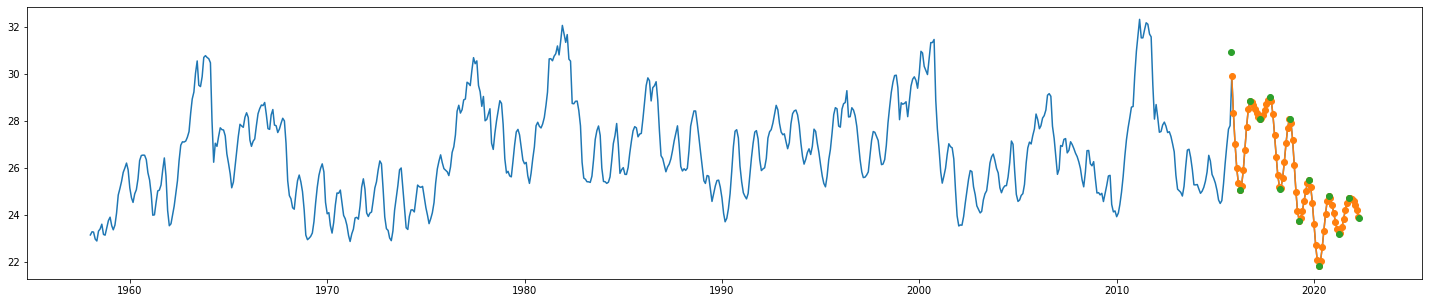

In [ ]:
#formating date for plotting
replaced_date =  pd.to_datetime(replaced_df.index.values)
#years_date =  pd.to_datetime(years_df.columns.values)

#plotting
fig, ax = plt.subplots(1, 1, figsize=(25,5))
ax.plot(replaced_date, replaced_df[replaced_df.columns[well_no]])
#ax.plot(imputed_date, imputed_df[imputed_df.columns[well_no]])
ax.plot(interp_date, well_interp_df[well_interp_df.columns[well_no]], marker = "o")
ax.plot(wells_date, wells_df[wells_df.columns[well_no]], marker = "o", linestyle = 'none')
#ax.plot(years_date, years_df[years_df.index[well_no]], marker = "o", linestyle = 'none', color = 'red')

# Spatial Interpolation

In [ ]:
#@markdown ### **Setting Parameters for Spatial Interpolation**
raster_extent = "aquifer"
start_date = 2001
end_date = 2021
#let user pick the entire date
raster_interval = 12
output_file = "results.nc"
aquifer_name = "sunflower"
units = "acre-ft"

In [ ]:
#@markdown ### **Defining functions for this section**

def create_grid_coords(x_c, y_c, x_steps, bbox, raster_extent):
    # create grid coordinates fro kriging, make x and y steps the same
    # x_steps is the number of cells in the x-direction
    min_x = min_y = max_x = max_y = None
    if raster_extent == "aquifer":
        min_x, min_y, max_x, max_y = bbox
    elif raster_extent == "wells":
        min_x, max_x = min(x_c), max(x_c)
        min_y, max_y = min(y_c), max(y_c)

    n_bin = np.absolute((max_x - min_x) / x_steps)  # determine step size (positive)
    # make grid 10 bin steps bigger than date, will give 110 steps in x-direction
    grid_x = np.arange(
        min_x - 5 * n_bin, max_x + 5 * n_bin, n_bin
    )  # make grid 10 steps bigger than data
    grid_y = np.arange(
        min_y - 5 * n_bin, max_y + 5 * n_bin, n_bin
    )  # make grid 10 steps bigger than data

    return grid_x, grid_y

def krig_field_generate(var_fitted, x_c, y_c, values, grid_x, grid_y):
    # use GSTools to krig  the well data, need coords and value for each well
    # use model variogram paramters generated by GSTools
    # fast - is faster the variogram fitting
    krig_map = gs.krige.Ordinary(var_fitted, cond_pos=[x_c, y_c], cond_val=values)
    krig_map.structured([grid_x, grid_y], chunk_size=1000)  # krig_map.field is the numpy array of values
    return krig_map    

def fit_model_var(x_c, y_c, values, bbox, raster_extent):
    # fit the model varigrom to the experimental variogram
    min_x = min_y = max_x = max_y = None
    if raster_extent == "aquifer":
        min_x, min_y, max_x, max_y = bbox
    elif raster_extent == "wells":
        min_x, max_x = min(x_c), max(x_c)
        min_y, max_y = min(y_c), max(y_c)

    # first get the coords and determine distances
    x_delta = max_x - min_x  # distance across x coords
    y_delta = max_y - min_y  # distance across y coords
    max_dist = (
        np.sqrt(np.square(x_delta + y_delta)) / 4
    )  # assume correlated over 1/4 of distance
    data_var = np.var(values)
    data_std = np.std(values)
    fit_var = gs.Stable(dim=2, var=data_var, len_scale=max_dist, nugget=data_std)
    return fit_var

def generate_nc_file(
    file_name, grid_x, grid_y, years_df, x_coords, y_coords, bbox, raster_extent
):
    temp_dir = tempfile.mkdtemp()
    file_path = os.path.join(temp_dir, file_name)
    h = netCDF4.Dataset(file_path, "w", format="NETCDF4")
    lat_len = len(grid_y)
    lon_len = len(grid_x)
    time_dim = h.createDimension("time", 0)
    lat = h.createDimension("lat", lat_len)
    lon = h.createDimension("lon", lon_len)
    latitude = h.createVariable("lat", np.float64, ("lat"))
    longitude = h.createVariable("lon", np.float64, ("lon"))
    time_dim = h.createVariable("time", np.float64, ("time"), fill_value="NaN")
    ts_value = h.createVariable(
        "tsvalue", np.float64, ("time", "lon", "lat"), fill_value=-9999
    )
    latitude.long_name = "Latitude"
    latitude.units = "degrees_north"
    latitude.axis = "Y"
    longitude.long_name = "Longitude"
    longitude.units = "degrees_east"
    longitude.axis = "X"
    time_dim.axis = "T"
    time_dim.units = "days since 0001-01-01 00:00:00 UTC"

    latitude[:] = grid_y[:]
    longitude[:] = grid_x[:]

    time_counter = 0
    for measurement in years_df:
        # loop through the data
        values = years_df[measurement].values

        beg_time = timer()  # time the kriging method including variogram fitting
        # fit the model variogram to the experimental variogram
        var_fitted = fit_model_var(
            x_coords, y_coords, values, bbox, raster_extent
        )  # fit variogram
        krig_map = krig_field_generate(
            var_fitted, x_coords, y_coords, values, grid_x, grid_y
        )  # krig data
        # krig_map.field provides the 2D array of values
        end_time = timer()
        time_dim[time_counter] = measurement.toordinal()
        ts_value[time_counter, :, :] = krig_map.field
        time_counter += 1

    h.close()
    return Path(file_path)

def earth_radius(lat):
    """
    calculate radius of Earth assuming oblate spheroid
    defined by WGS84
    Input
    ---------
    lat: vector or latitudes in degrees
    Output
    ----------
    r: vector of radius in meters
    Notes
    -----------
    WGS84: https://earth-info.nga.mil/GandG/publications/tr8350.2/tr8350.2-a/Chapter%203.pdf
    Taken from: https://gist.github.com/lgloege/3fdb1ed83b002d68d8944539a797b0bc
    """
    from numpy import deg2rad

    # define oblate spheroid from WGS84
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b ** 2 / a ** 2)

    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
    lat = deg2rad(lat)
    lat_gc = np.arctan((1 - e2) * np.tan(lat))

    # radius equation
    # see equation 3-107 in WGS84
    r = (a * (1 - e2) ** 0.5) / (1 - (e2 * np.cos(lat_gc) ** 2)) ** 0.5

    return r

def calculate_aquifer_area(imputed_raster, units):
    y_res = abs(
        round(imputed_raster["lat"].values[0] - imputed_raster["lat"].values[1], 7)
    )  # this assumes all cells will be the same
    # size in one dimension (all cells will have same x-component)
    x_res = abs(
        round(imputed_raster["lon"].values[0] - imputed_raster["lon"].values[1], 7)
    )
    area = 0
    # Loop through each y row
    for y in range(imputed_raster.lat.size):
        # Define the upper and lower bounds of the row
        cur_lat_max = math.radians(imputed_raster["lat"].values[y] + (y_res / 2))
        cur_lat_min = math.radians(imputed_raster["lat"].values[y] - (y_res / 2))

        # Count how many cells in each row are in aquifer (i.e. and, therefore, not nan)
        x_count = np.count_nonzero(~np.isnan(imputed_raster.tsvalue[0, :, y]))

        # Area calculated based on the equation found here:
        # https://www.pmel.noaa.gov/maillists/tmap/ferret_users/fu_2004/msg00023.html
        #     (pi/180) * R^2 * |lon1-lon2| * |sin(lat1)-sin(lat2)|
        radius = earth_radius(imputed_raster["lat"].values[y])
        if units == "acre-ft":
            area_factor = 1 / 4046.8564224
        elif units == "cubic-ft":
            area_factor = 10.764
        else:
            area_factor = 1
        area += (
            radius ** 2
            * area_factor
            * math.radians(x_res * x_count)
            * abs((math.sin(cur_lat_min) - math.sin(cur_lat_max)))
        )

    return area

In [ ]:
#@markdown ### **Setting up grid for nc file**
coords_df = wells_gdf[wells_gdf.Well_ID.astype(str).isin(loc_well_names)]
x_coords = coords_df.long_dec.values
y_coords = coords_df.lat_dec.values

x_steps = 150  # steps in x-direction, number of y-steps will be computed with same spacing, adds 10%
grid_x, grid_y = create_grid_coords(
    x_coords, y_coords, x_steps, bbox, raster_extent
)  # coordinates for x and y axis - not full grid
imputed_df = imputed_df[
    (imputed_df.index >= f"04-01-{start_date+1}")
    & (imputed_df.index <= f"12-31-{end_date+1}")
]
# skip_month = 48  # take data every nth month (skip_months), e.g., 60 = every 5 years
years_df = imputed_df.iloc[
    ::raster_interval
].T  # extract every nth month of data and transpose array

file_name = f"{aquifer_name}_{time.time()}.nc"
# setup a netcdf file to store the time series of rasters

In [ ]:
years_df

,2002-04-01,2003-04-01,2004-04-01,2005-04-01,2006-04-01,2007-04-01,2008-04-01,2009-04-01,2010-04-01,2011-04-01,2012-04-01,2013-04-01,2014-04-01,2015-04-01,2016-04-01,2017-04-01,2018-04-01,2019-04-01,2020-04-01
331615090422801,23.928784,24.631109,25.127938,24.896772,28.111060,26.906145,25.482705,24.911211,24.964610,31.520727,27.538644,24.951918,24.909842,24.479830,25.094505,27.786436,25.604156,23.958620,22.703876
331655090350401,29.484954,28.199383,27.432990,25.768344,26.212603,27.833378,29.084948,28.389774,26.019549,29.786490,30.432040,29.997140,29.228192,29.384813,29.864430,31.593799,30.783670,30.112927,29.069249
331751090395201,32.859957,31.400591,29.905054,27.451254,27.437834,29.787789,31.449423,31.094405,29.450608,31.413177,32.055450,31.914608,31.918283,32.552267,31.642910,33.594687,33.714392,32.983313,30.571014
331759090435201,29.896895,29.117932,28.945505,28.343952,29.457194,30.425500,31.032822,29.247856,27.302982,28.822095,29.939070,30.643927,29.895162,29.842435,28.321469,29.989274,28.961328,29.467073,29.539899
331831090443101,25.300224,25.306263,25.604442,24.758233,25.401114,26.118364,26.345548,25.375079,24.480651,26.946064,26.394782,25.680124,25.764134,25.868403,25.884066,27.351915,26.191603,25.464386,24.924940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335701090385601,41.208658,40.618722,39.828878,38.764829,38.699340,39.448065,39.967390,40.063146,39.176591,40.339896,40.860233,40.796579,40.602360,40.952831,41.119228,42.902696,43.329269,43.152756,42.276599
335701090385602,41.864237,40.656329,39.870410,38.849790,38.410203,39.716927,40.823390,40.798423,39.071152,40.540501,41.331391,41.484835,41.272384,41.750567,41.760132,43.340393,43.653548,43.331285,41.975478
335849090333601,46.946217,45.420644,43.479701,41.278270,40.610617,42.421545,44.166349,44.655646,45.021706,44.675877,45.382871,46.221736,45.435434,45.597406,44.167218,44.700320,45.393591,45.201539,42.310646
335851090333901,41.688661,41.825720,41.813678,41.982287,41.703123,41.861720,41.631088,41.847335,42.073766,41.902928,41.735193,41.523638,41.741428,41.745029,41.706750,41.974451,41.609373,41.725151,41.758213


In [ ]:
#@markdown ### **Generate nc file using kriging**
nc_file_path = generate_nc_file(file_name, grid_x, grid_y, years_df, x_coords, y_coords, bbox, raster_extent)

In [ ]:
#@markdown ### **Assigning dimensions and clipping nc file**
file_path = nc_file_path
temp_dir = file_path.parent.absolute()
interp_nc = xarray.open_dataset(file_path)
interp_nc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
interp_nc.rio.write_crs("epsg:4326", inplace=True)
clipped_nc = interp_nc.rio.clip(aquifer.geometry.apply(mapping), crs=4326, drop=True)

In [ ]:
#@markdown ### **Calculating drawdown**
area = calculate_aquifer_area(clipped_nc, units)
if units == "acre-ft":
    vol_unit = "Acre Feet"
elif units == "cubic-ft":
    vol_unit = "Cubic Feet"
else:
    vol_unit = "Cubic Meters"
# Calculate total drawdown volume at each time step
drawdown_grid = np.zeros(
    (clipped_nc.time.size, clipped_nc.lon.size, clipped_nc.lat.size)
)
drawdown_volume = np.zeros(clipped_nc.time.size)
for t in range(clipped_nc.time.size):
    # Calculate drawdown at time t by subtracting original WTE at time 0
    drawdown_grid[t, :, :] = (
        clipped_nc["tsvalue"][t, :, :] - clipped_nc["tsvalue"][0, :, :]
    )
    # Average drawdown across entire aquifer x storage_coefficient x area of aquifer
    drawdown_volume[t] = np.nanmean(
        drawdown_grid[t, :, :] * 0.1 * area
    )
print(area, units)
print(type(clipped_nc))
clipped_nc.attrs = {"area": area, "area_units": units}
clipped_nc["drawdown"] = (["time", "lon", "lat"], drawdown_grid)
clipped_nc["volume"] = (["time"], drawdown_volume, {"units": vol_unit})

451738.6488860603 acre-ft
<class 'xarray.core.dataset.Dataset'>


In [ ]:
#@markdown ### **Saving to notebook**
clipped_nc.to_netcdf(aquifer_name + output_file)